In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-12-12 16:35:05.668893: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 16:35:05.675008: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 16:35:05.749010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 16:35:05.811868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734017705.861555    1535 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734017705.87

# Data viz

In [3]:
file = "../raw_data/mta_1706.csv"
data = pd.read_csv(file, on_bad_lines="skip")
data.head(10)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,24:00:53
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,23:59:38
5,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,24:02:35
6,2017-06-01 00:03:24,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,40.587024,-73.918623,GERRITSEN AV/GERRITSEN BEACH,at stop,0.0,NaN,24:08:00
7,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,23:58:47
8,2017-06-01 00:03:27,0,B82,STILLWELL TERMINAL BUS LOOP,40.577080,-73.981293,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6592,40.632258,-73.918318,FLATLANDS AV/RALPH AV,approaching,35.0,2017-06-01 00:03:56,24:00:00
9,2017-06-01 00:03:51,1,S59,RICHMOND TER/PARK AV #3,40.640167,-74.130966,HYLAN BL,40.534260,-74.154213,NYCT_8279,40.590689,-74.165811,RICHMOND AV/NOME AV,approaching,31.0,2017-06-01 00:03:56,24:01:14


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   RecordedAtTime             object 
 1   DirectionRef               int64  
 2   PublishedLineName          object 
 3   OriginName                 object 
 4   OriginLat                  float64
 5   OriginLong                 float64
 6   DestinationName            object 
 7   DestinationLat             float64
 8   DestinationLong            float64
 9   VehicleRef                 object 
 10  VehicleLocation.Latitude   float64
 11  VehicleLocation.Longitude  float64
 12  NextStopPointName          object 
 13  ArrivalProximityText       object 
 14  DistanceFromStop           float64
 15  ExpectedArrivalTime        object 
 16  ScheduledArrivalTime       object 
dtypes: float64(7), int64(1), object(9)
memory usage: 872.9+ MB


In [5]:
data.dtypes

RecordedAtTime                object
DirectionRef                   int64
PublishedLineName             object
OriginName                    object
OriginLat                    float64
OriginLong                   float64
DestinationName               object
DestinationLat               float64
DestinationLong              float64
VehicleRef                    object
VehicleLocation.Latitude     float64
VehicleLocation.Longitude    float64
NextStopPointName             object
ArrivalProximityText          object
DistanceFromStop             float64
ExpectedArrivalTime           object
ScheduledArrivalTime          object
dtype: object

## Convert Time Columns to Datetime Format

In [6]:
data['RecordedAtTime'] = pd.to_datetime(data['RecordedAtTime'])
data['ExpectedArrivalTime'] = pd.to_datetime(data['ExpectedArrivalTime'])

In [7]:
# Using Vectorized Operations
# since the db is very very large and classical python iterations is too slow.

times = data['ScheduledArrivalTime'].str.split(':', expand=True)
times = times.fillna('0').astype(float)
hours, minutes, seconds = times[0], times[1], times[2]

new_hours = np.where(hours >= 24, hours - 24, hours)
days_to_add = np.where(hours >= 24, 1, 0)

valid_rows = ~hours.isna() & ~minutes.isna() & ~seconds.isna()

data.loc[valid_rows, 'ScheduledArrivalTime'] = (
    pd.to_datetime(
        new_hours.astype(int).astype(str) + ':' +
        minutes.astype(int).astype(str) + ':' +
        seconds.astype(int).astype(str),
        format='%H:%M:%S'
    ) + pd.to_timedelta(days_to_add[valid_rows], unit='days')
)

data.loc[~valid_rows, 'ScheduledArrivalTime'] = pd.NaT

In [8]:
data['ScheduledArrivalTime'] = pd.to_datetime(data['ScheduledArrivalTime'])

In [9]:
data['ScheduledArrivalTime'] = (
    pd.to_datetime(data['RecordedAtTime'].dt.date.astype(str) + ' ' + data['ScheduledArrivalTime'].dt.time.astype(str))
)
data['ScheduledArrivalTime']

0         2017-06-01 00:06:14
1         2017-06-01 23:58:02
2         2017-06-01 00:00:53
3         2017-06-01 00:03:00
4         2017-06-01 23:59:38
                  ...        
6730431   2017-06-30 23:44:12
6730432   2017-06-30 00:02:00
6730433   2017-06-30 23:44:16
6730434   2017-06-30 23:50:00
6730435   2017-06-30 23:45:15
Name: ScheduledArrivalTime, Length: 6730436, dtype: datetime64[ns]

In [10]:
print(data['RecordedAtTime'].isna().sum())

0


In [11]:
print(data['ExpectedArrivalTime'].isna().sum())

872302


In [12]:
print(data['ScheduledArrivalTime'].isna().sum())

0


## Data Cleaning

In [13]:
# List of columns to drop
columns_to_drop = ['PublishedLineName', 'OriginName', 'DestinationName', 'VehicleRef', 'NextStopPointName', 'ArrivalProximityText']

# Drop the columns
data_cleaned = data.drop(columns=columns_to_drop)

In [14]:
# Drop rows where 'ExpectedArrivalTime' is missing (since it's needed for target)
data_cleaned = data_cleaned.dropna()

In [15]:
# Inspect the data after handling missing values
data_cleaned.isnull().sum()

RecordedAtTime               0
DirectionRef                 0
OriginLat                    0
OriginLong                   0
DestinationLat               0
DestinationLong              0
VehicleLocation.Latitude     0
VehicleLocation.Longitude    0
DistanceFromStop             0
ExpectedArrivalTime          0
ScheduledArrivalTime         0
dtype: int64

In [16]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5804368 entries, 0 to 6730435
Data columns (total 11 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   RecordedAtTime             datetime64[ns]
 1   DirectionRef               int64         
 2   OriginLat                  float64       
 3   OriginLong                 float64       
 4   DestinationLat             float64       
 5   DestinationLong            float64       
 6   VehicleLocation.Latitude   float64       
 7   VehicleLocation.Longitude  float64       
 8   DistanceFromStop           float64       
 9   ExpectedArrivalTime        datetime64[ns]
 10  ScheduledArrivalTime       datetime64[ns]
dtypes: datetime64[ns](3), float64(7), int64(1)
memory usage: 531.4 MB


In [17]:
# Remove duplicate rows if any
data_cleaned = data_cleaned.drop_duplicates()

In [18]:
# Calculate the time difference between ExpectedArrivalTime and ScheduledArrivalTime
data_cleaned['TimeDifference'] = (data_cleaned['ExpectedArrivalTime'] - data_cleaned['ScheduledArrivalTime']).dt.total_seconds() / 60

# Inspect the data with the new target column
data_cleaned[['ExpectedArrivalTime', 'ScheduledArrivalTime', 'TimeDifference']].head(10)

,ExpectedArrivalTime,ScheduledArrivalTime,TimeDifference
0,2017-06-01 00:03:59,2017-06-01 00:06:14,-2.250000
1,2017-06-01 00:03:56,2017-06-01 23:58:02,-1434.100000
2,2017-06-01 00:03:56,2017-06-01 00:00:53,3.050000
3,2017-06-01 00:04:03,2017-06-01 00:03:00,1.050000
4,2017-06-01 00:03:56,2017-06-01 23:59:38,-1435.700000
5,2017-06-01 00:03:56,2017-06-01 00:02:35,1.350000
7,2017-06-01 00:04:13,2017-06-01 23:58:47,-1434.566667
8,2017-06-01 00:03:56,2017-06-01 00:00:00,3.933333
9,2017-06-01 00:03:56,2017-06-01 00:01:14,2.700000
10,2017-06-01 00:04:29,2017-06-01 23:48:35,-1424.100000


In [19]:
# Removing outliers by keeping values that are between -100 and 100 minutes
Q1 = data_cleaned["TimeDifference"].quantile(0.25)
Q3 = data_cleaned["TimeDifference"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_cleaned = data_cleaned[data_cleaned["TimeDifference"].between(lower_bound, upper_bound, inclusive="both")]

In [20]:
data_cleaned

,RecordedAtTime,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,TimeDifference
0,2017-06-01 00:03:34,0,40.616104,-74.031143,40.656048,-73.907379,40.635170,-73.960803,76.0,2017-06-01 00:03:59,2017-06-01 00:06:14,-2.250000
2,2017-06-01 00:03:49,0,40.875008,-73.880142,40.912376,-73.902534,40.886010,-73.912647,5.0,2017-06-01 00:03:56,2017-06-01 00:00:53,3.050000
3,2017-06-01 00:03:31,0,40.701748,-73.802399,40.666012,-73.735939,40.668002,-73.729348,267.0,2017-06-01 00:04:03,2017-06-01 00:03:00,1.050000
5,2017-06-01 00:03:40,0,40.731342,-73.990288,40.821110,-73.935898,40.792897,-73.950023,73.0,2017-06-01 00:03:56,2017-06-01 00:02:35,1.350000
8,2017-06-01 00:03:27,0,40.577080,-73.981293,40.642990,-73.878326,40.632258,-73.918318,35.0,2017-06-01 00:03:56,2017-06-01 00:00:00,3.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
6730429,2017-06-30 23:53:12,0,40.756550,-73.990120,40.814907,-73.955048,40.767813,-73.981383,44.0,2017-06-30 23:53:39,2017-06-30 23:47:00,6.650000
6730431,2017-06-30 23:53:37,0,40.694504,-73.987122,40.700527,-73.910149,40.699765,-73.911974,47.0,2017-06-30 23:53:52,2017-06-30 23:44:12,9.666667
6730433,2017-06-30 23:53:21,1,40.848522,-73.937706,40.747791,-73.988831,40.820420,-73.955842,120.0,2017-06-30 23:54:27,2017-06-30 23:44:16,10.183333
6730434,2017-06-30 23:53:34,0,40.749405,-73.991020,40.859013,-73.934250,40.797009,-73.948954,22.0,2017-06-30 23:53:42,2017-06-30 23:50:00,3.700000


In [21]:
# Reset index after cleaning
data_cleaned = data_cleaned.reset_index(drop=True)
data_cleaned

,RecordedAtTime,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,TimeDifference
0,2017-06-01 00:03:34,0,40.616104,-74.031143,40.656048,-73.907379,40.635170,-73.960803,76.0,2017-06-01 00:03:59,2017-06-01 00:06:14,-2.250000
1,2017-06-01 00:03:49,0,40.875008,-73.880142,40.912376,-73.902534,40.886010,-73.912647,5.0,2017-06-01 00:03:56,2017-06-01 00:00:53,3.050000
2,2017-06-01 00:03:31,0,40.701748,-73.802399,40.666012,-73.735939,40.668002,-73.729348,267.0,2017-06-01 00:04:03,2017-06-01 00:03:00,1.050000
3,2017-06-01 00:03:40,0,40.731342,-73.990288,40.821110,-73.935898,40.792897,-73.950023,73.0,2017-06-01 00:03:56,2017-06-01 00:02:35,1.350000
4,2017-06-01 00:03:27,0,40.577080,-73.981293,40.642990,-73.878326,40.632258,-73.918318,35.0,2017-06-01 00:03:56,2017-06-01 00:00:00,3.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
5368347,2017-06-30 23:53:12,0,40.756550,-73.990120,40.814907,-73.955048,40.767813,-73.981383,44.0,2017-06-30 23:53:39,2017-06-30 23:47:00,6.650000
5368348,2017-06-30 23:53:37,0,40.694504,-73.987122,40.700527,-73.910149,40.699765,-73.911974,47.0,2017-06-30 23:53:52,2017-06-30 23:44:12,9.666667
5368349,2017-06-30 23:53:21,1,40.848522,-73.937706,40.747791,-73.988831,40.820420,-73.955842,120.0,2017-06-30 23:54:27,2017-06-30 23:44:16,10.183333
5368350,2017-06-30 23:53:34,0,40.749405,-73.991020,40.859013,-73.934250,40.797009,-73.948954,22.0,2017-06-30 23:53:42,2017-06-30 23:50:00,3.700000


## Feature engineering

## Set target and features

In [42]:
data_sampled = data_cleaned.sample(n=1000000, random_state=42)

In [44]:
#Run the cyclical cell to run this one first (sorry for the inconvenience)

y = data_sampled["TimeDifference"]

X = data_sampled[[
    "DirectionRef",
    "OriginLat",
    "OriginLong",
    "DestinationLat",
    "DestinationLong",
    "VehicleLocation.Latitude",
    "VehicleLocation.Longitude",
    "DistanceFromStop",
    "Day_sin",
    "Day_cos",
    "Hour_sin",
    "Hour_cos",
    "Minute_sin",
    "Minute_cos",
]]

In [ ]:
X.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5368352 entries, 0 to 5368351
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   DirectionRef               int64  
 1   OriginLat                  float64
 2   OriginLong                 float64
 3   DestinationLat             float64
 4   DestinationLong            float64
 5   VehicleLocation.Latitude   float64
 6   VehicleLocation.Longitude  float64
 7   DistanceFromStop           float64
 8   Day_sin                    float64
 9   Day_cos                    float64
 10  Hour_sin                   float64
 11  Hour_cos                   float64
 12  Minute_sin                 float64
 13  Minute_cos                 float64
dtypes: float64(13), int64(1)
memory usage: 573.4 MB
<class 'pandas.core.series.Series'>
RangeIndex: 5368352 entries, 0 to 5368351
Series name: TimeDifference
Non-Null Count    Dtype  
--------------    -----  
5368352 non-null  float64
dtypes: fl

(None, None)

## Feature scaling

In [26]:
# Inspect the shapes of X and y
print(X.shape, y.shape)

(100000, 14) (100000,)


In [ ]:
X.head(5)

,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,DistanceFromStop,Day_sin,Day_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos
0,0,40.616104,-74.031143,40.656048,-73.907379,40.635170,-73.960803,76.0,0.204552,0.978856,0.0,1.0,0.309017,0.951057
1,0,40.875008,-73.880142,40.912376,-73.902534,40.886010,-73.912647,5.0,0.204552,0.978856,0.0,1.0,0.309017,0.951057
2,0,40.701748,-73.802399,40.666012,-73.735939,40.668002,-73.729348,267.0,0.204552,0.978856,0.0,1.0,0.406737,0.913545
3,0,40.731342,-73.990288,40.821110,-73.935898,40.792897,-73.950023,73.0,0.204552,0.978856,0.0,1.0,0.309017,0.951057
4,0,40.577080,-73.981293,40.642990,-73.878326,40.632258,-73.918318,35.0,0.204552,0.978856,0.0,1.0,0.309017,0.951057


In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
DirectionRef,5368352.0,0.501647,0.499997,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000
OriginLat,5368352.0,40.729948,0.091010,40.506882,40.657738,4.071523e+01,4.080962e+01,40.912365
OriginLong,5368352.0,-73.930370,0.094628,-74.248062,-73.987022,-7.393216e+01,-7.387833e+01,-73.701866
DestinationLat,5368352.0,40.729452,0.090349,40.508106,40.660854,4.071461e+01,4.080908e+01,40.912376
DestinationLong,5368352.0,-73.930431,0.094677,-74.248192,-73.988724,-7.393206e+01,-7.387712e+01,-73.701385
VehicleLocation.Latitude,5368352.0,40.729040,0.087242,40.502879,40.659091,4.072396e+01,4.080479e+01,40.912385
VehicleLocation.Longitude,5368352.0,-73.929923,0.088972,-74.252339,-73.978577,-7.393538e+01,-7.388135e+01,-73.701417
DistanceFromStop,5368352.0,234.427751,959.812906,0.000000,32.000000,1.040000e+02,2.110000e+02,33608.000000
Day_sin,5368352.0,0.014976,0.710211,-0.999668,-0.697944,5.147875e-02,7.338854e-01,0.997018
Day_cos,5368352.0,-0.009583,0.703764,-0.998674,-0.716152,2.574791e-02,6.792733e-01,0.994700


## Standardising X

In [45]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [46]:
# Normalize target variable y (TimeDifference)
y = data_sampled["TimeDifference"]
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [47]:
# Flatten y_scaled to 1D array
y_flat = y_scaled.ravel()

# Convert y_scaled to a Pandas Series
y_scaled = pd.Series(y_flat, name='target')

# Concatenate X_scaled and y_scaled (now a Series)
df_combined = pd.concat([X_scaled, y_scaled], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_combined.corr()

# Display the correlation matrix
print(correlation_matrix)

                           DirectionRef  OriginLat  OriginLong  \
DirectionRef                   1.000000   0.247205    0.263663   
OriginLat                      0.247205   1.000000    0.420649   
OriginLong                     0.263663   0.420649    1.000000   
DestinationLat                -0.249547   0.699009    0.305424   
DestinationLong               -0.273215   0.304417    0.638724   
VehicleLocation.Latitude      -0.001950   0.883790    0.392938   
VehicleLocation.Longitude     -0.007742   0.386894    0.856143   
DistanceFromStop              -0.002314  -0.050397   -0.105906   
Day_sin                        0.002141   0.006094    0.003305   
Day_cos                        0.000257   0.003695   -0.001433   
Hour_sin                      -0.018880  -0.050861   -0.029229   
Hour_cos                      -0.000453  -0.005982    0.009427   
Minute_sin                     0.002731   0.001581    0.000163   
Minute_cos                     0.000590   0.000562    0.000780   
target    

In [29]:
correlation = data_cleaned['DistanceFromStop'].corr(data_cleaned['ScheduledArrivalTime'])
print("Correlation between DistanceFromStop and TimeDifference:", correlation)

Correlation between DistanceFromStop and TimeDifference: 0.00030602803085938


# Cyclical Encoding for timetables

In [43]:
def cyclical_encoding(data, column, max_val, prefix):
    data[f"{prefix}_sin"] = np.sin(2 * np.pi * data[column] / max_val)
    data[f"{prefix}_cos"] = np.cos(2 * np.pi * data[column] / max_val)
    return data

data_sampled['ArrivalDay'] = data_sampled['ExpectedArrivalTime'].dt.day
data_sampled['ArrivalHour'] = data_sampled['ExpectedArrivalTime'].dt.hour
data_sampled['ArrivalMinute'] = data_sampled['ExpectedArrivalTime'].dt.minute
data_sampled['ArrivalSecond'] = data_sampled['ExpectedArrivalTime'].dt.second

data_sampled = cyclical_encoding(data=data_sampled, column="ArrivalDay", max_val=30.5, prefix="Day")
data_sampled = cyclical_encoding(data=data_sampled, column="ArrivalHour", max_val=24, prefix="Hour")
data_sampled = cyclical_encoding(data=data_sampled, column="ArrivalMinute", max_val=60, prefix="Minute")
data_sampled = cyclical_encoding(data=data_sampled, column="ArrivalSecond", max_val=60, prefix="Second")

In [ ]:
data_cleaned.head(5)

,RecordedAtTime,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,DistanceFromStop,ExpectedArrivalTime,...,ArrivalMinute,ArrivalSecond,Day_sin,Day_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos,Second_sin,Second_cos
0,2017-06-01 00:03:34,0,40.616104,-74.031143,40.656048,-73.907379,40.635170,-73.960803,76.0,2017-06-01 00:03:59,...,3,59,0.204552,0.978856,0.0,1.0,0.309017,0.951057,-0.104528,0.994522
1,2017-06-01 00:03:49,0,40.875008,-73.880142,40.912376,-73.902534,40.886010,-73.912647,5.0,2017-06-01 00:03:56,...,3,56,0.204552,0.978856,0.0,1.0,0.309017,0.951057,-0.406737,0.913545
2,2017-06-01 00:03:31,0,40.701748,-73.802399,40.666012,-73.735939,40.668002,-73.729348,267.0,2017-06-01 00:04:03,...,4,3,0.204552,0.978856,0.0,1.0,0.406737,0.913545,0.309017,0.951057
3,2017-06-01 00:03:40,0,40.731342,-73.990288,40.821110,-73.935898,40.792897,-73.950023,73.0,2017-06-01 00:03:56,...,3,56,0.204552,0.978856,0.0,1.0,0.309017,0.951057,-0.406737,0.913545
4,2017-06-01 00:03:27,0,40.577080,-73.981293,40.642990,-73.878326,40.632258,-73.918318,35.0,2017-06-01 00:03:56,...,3,56,0.204552,0.978856,0.0,1.0,0.309017,0.951057,-0.406737,0.913545


# Deploying baseline model

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [49]:
model = RandomForestRegressor(bootstrap= False, max_depth= None, max_features= 'sqrt', min_samples_leaf= 4, min_samples_split= 10, n_estimators= 300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [50]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")

MAE: 0.6671170229965542, RMSE: 0.8755027636758691, R2: 0.23399204350036495


In [ ]:
#Interpretations
#MAE and RMSE indicates that these are quite low errors relative to the scale of the target variable (1/4 lb, 3/4hb)
#An R² value of 0.20(20%) is quite low, indicating that the model doesn't capture much of the variation in the target variable.


In [34]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

In [52]:
# Same as the 'model' cell, the return will be the result of the models perf with the best params
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

MAE: 0.7098417506917494, RMSE: 0.9219463247566972, R²: 0.15056624960882048


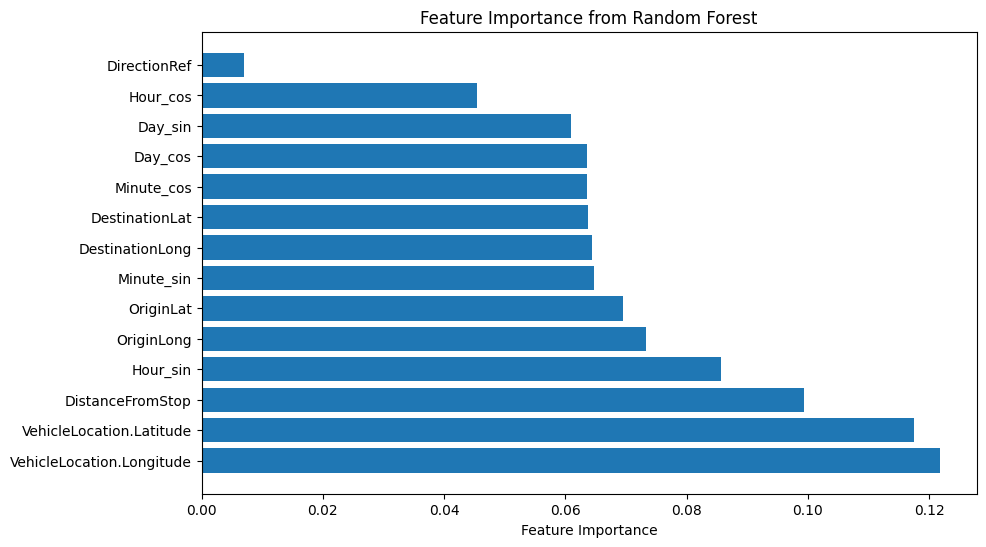

In [51]:
importances = best_model.feature_importances_
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([X.columns[i] for i in indices], [importances[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()